In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_fam_also_nov'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [4]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all = prepped_data_agg['var_res_all']
corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']


In [6]:
ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


# does pop up cell in fam also pop up in novel

In [7]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [14]:
subdb_two_tasks = subdb.loc[[x.startswith('[') for x in subdb['behavior']]]
sess_two_tasks = subdb_two_tasks['sess_name']
best_n_all_sess_two_tasks = best_n_all.loc[(slice(None),sess_two_tasks)]

ntrial_to_include_sess=ntrials_mask.loc[ntrials_mask].index.get_level_values(1)
ma=best_n_all_sess_two_tasks.index.get_level_values(1).isin(ntrial_to_include_sess)
best_n_all_sess_two_tasks=best_n_all_sess_two_tasks.loc[ma]

best_n_all_sess_two_tasks.index.get_level_values(1).isin(ntrial_to_include_sess)


pval_all_sub = pval_all.loc[(slice(None),sess_two_tasks),:]

ma=pval_all_sub.index.get_level_values(1).isin(ntrial_to_include_sess)
pval_all_sub = pval_all_sub.loc[ma]

pval_all_sub_min_per_neuron = pval_all_sub.groupby(level=(0,1,2,4)).apply(lambda x:x.loc[:,(slice(None),'pval')].min().min())
pval_all_sub_min_per_neuron_unstack=pval_all_sub_min_per_neuron.unstack(level=2)


In [ ]:
# pthresh_l = [0.001,0.003,0.005,0.007,0.01,0.03,0.05,0.08,0.1,0.13,0.16,0.2,0.23,0.25,0.28,0.3,0.33,0.35,0.4,0.45,0.5]
pthresh_l = [0.001,0.003,0.005,0.007,0.01,0.03,0.05,0.08,0.1,0.13,0.16,0.2]
chi_pval_l = []
for pthresh in pthresh_l:
    
    has_sw_per_uid_vs_novel_all = pval_all_sub_min_per_neuron_unstack.dropna(axis=0) < pthresh
    conf_mat=confusion_matrix(has_sw_per_uid_vs_novel_all[1],has_sw_per_uid_vs_novel_all[0])

    chi_pval=scipy.stats.chi2_contingency(conf_mat)
    chi_pval_l.append(chi_pval[1])
fig,ax=plt.subplots()
ax.plot(pthresh_l,chi_pval_l,marker='o')
ax.axhline(0.05)
sns.despine()
ax.set_xlabel('p-val. threshold for switching')
ax.set_ylabel('p-val. for chi2 test')





for fmt in ['png','svg']:
    fig_fn = f'pval_chi2_sweep_pvalthresh.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')



In [17]:
best_n_per_uid_vs_novel_all = best_n_all_sess_two_tasks.groupby(level=(0,1,2,4)).max().unstack(level=2)
best_n_per_uid_vs_novel_all = best_n_per_uid_vs_novel_all.dropna(axis=0,how='any')
has_sw_per_uid_vs_novel_all = best_n_per_uid_vs_novel_all > 0

Chi2ContingencyResult(statistic=1.3064270589656268, pvalue=0.25304257610487096, dof=1, expected_freq=array([[243.69295478, 247.30704522],
       [228.30704522, 231.69295478]]))


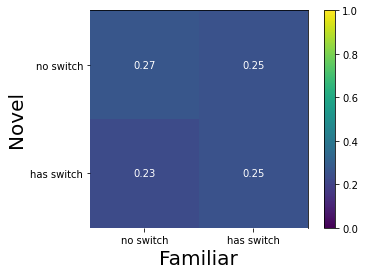

In [84]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat=confusion_matrix(has_sw_per_uid_vs_novel_all[1],has_sw_per_uid_vs_novel_all[0])
conf_mat_norm=confusion_matrix(has_sw_per_uid_vs_novel_all[1],has_sw_per_uid_vs_novel_all[0],normalize='all')
disp=ConfusionMatrixDisplay(conf_mat_norm)
disp=disp.plot()
ax=disp.ax_
disp.im_.set_clim([0,1])
[x.set_color('white') for x in disp.text_.ravel()]

ax.spines[['left','bottom']].set_visible(False)
ax.set(xlabel='Familiar',ylabel='Novel')
ticks = [0,1]
ticklabels=['no switch','has switch']
ax.set(xticks=ticks,yticks=ticks,xticklabels=ticklabels,yticklabels=ticklabels)
fig=ax.figure

print(scipy.stats.chi2_contingency(conf_mat))

fig_fn = 'has_switch_novel_vs_familiar_contingency.png'
fig_fn = os.path.join(figdir,fig_fn)
fig.savefig(fig_fn,bbox_inches='tight')


# visualization

In [7]:
import plot_ratemap_sequence as prs

In [11]:
ii=2
ani,sess=sess_two_tasks.index[ii],sess_two_tasks.values[ii]
ani = ani[0]
print(sess)
X_pwc_one = X_pwc_all.loc[(ani,sess),:].droplevel((0,1))
changes_df_one = changes_df_all.loc[(ani,sess),:].droplevel((0,1))

e15_13f1_220120


/tmp/ipykernel_737671/2160573797.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc_one = X_pwc_all.loc[(ani,sess),:].droplevel((0,1))
/tmp/ipykernel_737671/2160573797.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_one = changes_df_all.loc[(ani,sess),:].droplevel((0,1))


In [ ]:
# next: each row: trialtype for familiar, column: trialtype for novel, corresponding neurons, sorted according to the familiar order


In [40]:
# def get_change_ind(row):
#     '''
#     prioritize on (first consider the ind of first switch on), then off, then nothing
#     '''
#     row=row.values
#     inds = np.nonzero(row==1)[0]
#     if len(inds) > 0:
#         return pd.Series(['on',inds[0]])
#     else:
#         inds_off = np.nonzero(row==-1)[0]
#         if len(inds_off) >0:
#             return pd.Series(['off',inds_off[0]])
#         else:
#             return pd.Series(['nothing', 0])
    

# order_df=changes_df_one_tt.apply(lambda x:get_change_ind(x),axis=1,raw=False)
# order_df.columns=['onoff','index_within']

# order_df = order_df.sort_values(['onoff','index_within'])

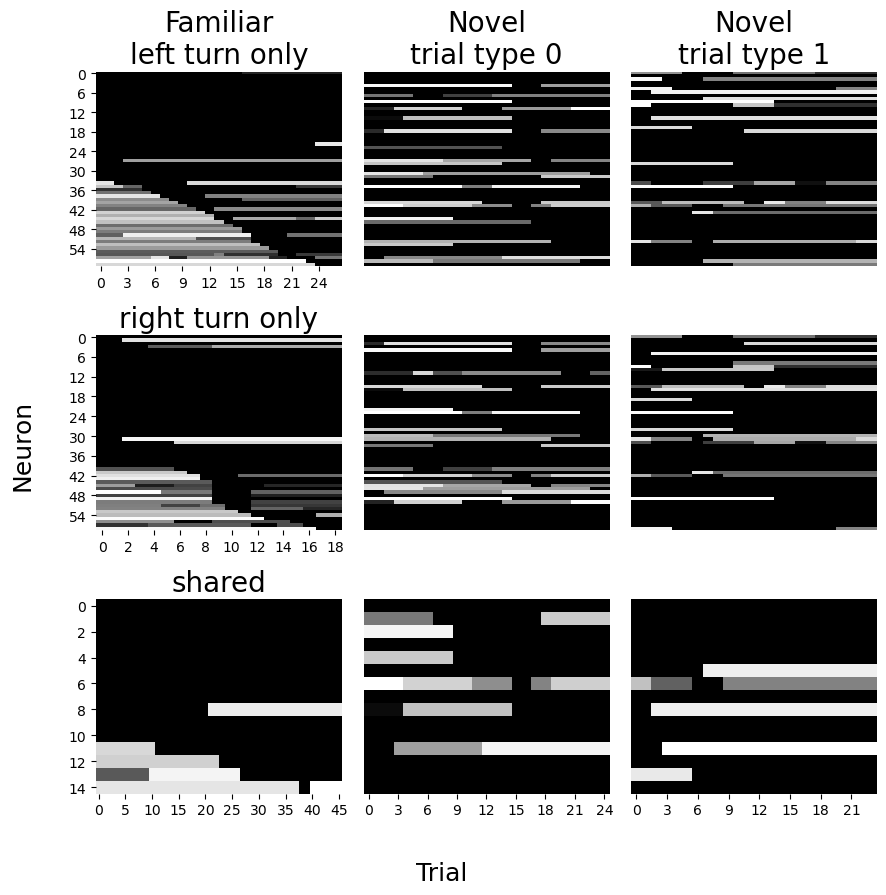

In [126]:
reload(prs)
from matplotlib.ticker import MaxNLocator
fig,axs = plt.subplots(3,3,figsize=(9,9))
mpl.rc('image', cmap='Greys')

for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for ii,tt in enumerate([0,1,'both']):
    X_pwc_one_tt_fam = X_pwc_one.loc[0,tt].dropna(axis=1,how='all')
    X_pwc_tt_0_nov = X_pwc_one.loc[1,0].dropna(axis=1,how='all')
    X_pwc_tt_1_nov = X_pwc_one.loc[1,1].dropna(axis=1,how='all')
    
    X_pwc_one_tt_fam_per_neuron = X_pwc_one_tt_fam.groupby(level=0).mean()
    X_pwc_tt_0_nov_per_neuron = X_pwc_tt_0_nov.groupby(level=0).mean()
    X_pwc_tt_1_nov_per_neuron = X_pwc_tt_1_nov.groupby(level=0).mean()
    
    common_uid = X_pwc_one_tt_fam_per_neuron.index.intersection(X_pwc_tt_0_nov_per_neuron.index).intersection(X_pwc_tt_1_nov_per_neuron.index)
    
    X_pwc_one_tt_fam_per_neuron = X_pwc_one_tt_fam_per_neuron.loc[common_uid]
    X_pwc_tt_0_nov_per_neuron = X_pwc_tt_0_nov_per_neuron.loc[common_uid]
    X_pwc_tt_1_nov_per_neuron = X_pwc_tt_1_nov_per_neuron.loc[common_uid]
    
    ax=axs[ii,0]
    fig,ax,order=prs.plot_population_sequence(X_pwc_one_tt_fam_per_neuron,order=None,fig=fig,ax=ax)
    
    ax=axs[ii,1]
    fig,ax,order=prs.plot_population_sequence(X_pwc_tt_0_nov_per_neuron,order=order,fig=fig,ax=ax)
    ax.set(yticks=[])
    
    ax=axs[ii,2]
    fig,ax,order=prs.plot_population_sequence(X_pwc_tt_1_nov_per_neuron,order=order,fig=fig,ax=ax)
    ax.set(yticks=[])


axs[0,0].set_title('Familiar\nleft turn only')
axs[1,0].set_title('right turn only')
axs[2,0].set_title('shared')
axs[0,1].set_title('Novel\ntrial type 0')
axs[0,2].set_title('Novel\ntrial type 1')

axs[0,1].set(xticks=[])
axs[1,1].set(xticks=[])
axs[0,2].set(xticks=[])
axs[1,2].set(xticks=[])

# for i in range(3):
#     ax=axs[i,2]
#     im=ax.get_images()[0]
#     fig.colorbar(im,ax=ax)
    


sns.despine(top=True, right=True, left=True, bottom=True)
fig.supxlabel('Trial',fontsize=18)
fig.supylabel('Neuron',fontsize=18)
plt.tight_layout(rect=(0.025,0.025,1,1))


for fmt in ['png','svg']:
    fig_fn = f'neuron_by_trial_within_field_fr_fam_vs_novel_{sess}.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')

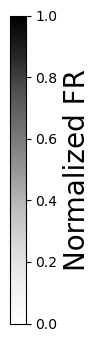

In [110]:
reload(ph)
fig,ax,cb=ph.plot_colorbar()
cb.set_label('Normalized FR')
for fmt in ['png','svg']:
    fig_fn = f'neuron_by_trial_within_field_fr_fam_vs_novel_cbar.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')

<bound method FigureBase.supxlabel of <Figure size 432x288 with 9 Axes>>

# compare continuous variables, like p value or var_exp_ratio

In [15]:
pval_all_sub = pval_all.loc[(slice(None),sess_two_tasks),:]

pval_all_sub_min_per_neuron = pval_all_sub.groupby(level=(0,1,2,4)).apply(lambda x:x.loc[:,(slice(None),'pval')].min().min())

pval_all_sub_min_per_neuron_unstack=pval_all_sub_min_per_neuron.unstack(level=2)

exp_var_ratio_all_sub_min_per_neuron = pval_all_sub.groupby(level=(0,1,2,4)).apply(lambda x:x.loc[:,(slice(None),'exp_var_ratio')].max().max())
exp_var_ratio_all_sub_min_per_neuron_unstack = exp_var_ratio_all_sub_min_per_neuron.unstack(level=2)


       0  1
0      -  *
1  0.077  -


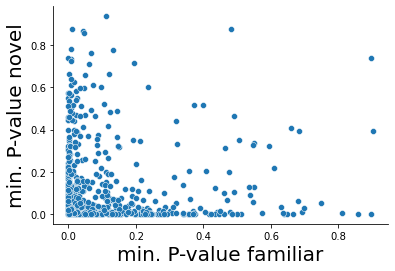

In [128]:
fig,ax=plt.subplots()
ax=sns.scatterplot(data=pval_all_sub_min_per_neuron_unstack,x=0,y=1,ax=ax)
sns.despine()
ax.set_xlabel('min. P-value familiar')
ax.set_ylabel('min. P-value novel')

print(pval_all_sub_min_per_neuron_unstack.rcorr())
for fmt in ['png','svg']:
    fig_fn = f'pval_novel_vs_fam.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')

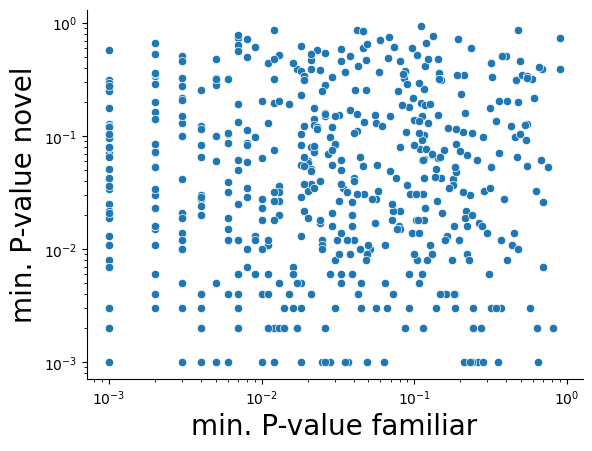

In [278]:
fig,ax=plt.subplots()
ax=sns.scatterplot(data=pval_all_sub_min_per_neuron_unstack,x=0,y=1,ax=ax)
sns.despine()
ax.set_xlabel('min. P-value familiar')
ax.set_ylabel('min. P-value novel')
ax.set_xscale('log')
ax.set_yscale('log')

for fmt in ['png','svg']:
    fig_fn = f'pval_novel_vs_fam_log.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')

       0  1
0      -   
1  0.058  -


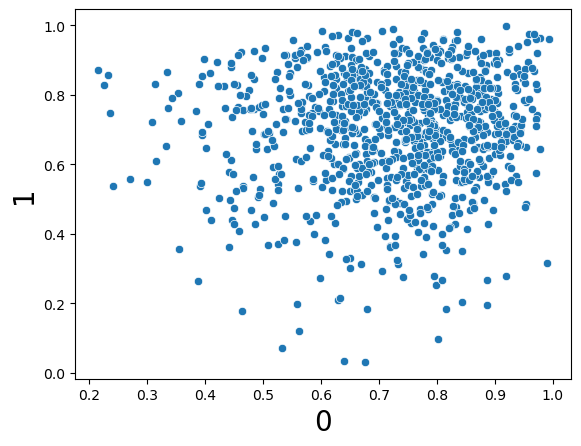

In [523]:
sns.scatterplot(data=exp_var_ratio_all_sub_min_per_neuron_unstack,x=0,y=1)
print(exp_var_ratio_all_sub_min_per_neuron_unstack.rcorr())

# more continuous var

In [489]:
X_pwc_sub

0          1         2   \
e15_13f1 e15_13f1_220118 0 0.0 39  0       NaN   6.238005       NaN   
                                   1       NaN  10.127204       NaN   
                                   2       NaN   4.921648       NaN   
                                   3       NaN   8.963377       NaN   
                               40  2       NaN   3.716957       NaN   
...                                        ...        ...       ...   
e13_26m1 e13_26m1_211119 1 1.0 180 0  7.561522   7.561522  7.561522   
                               181 0  7.494872   7.494872  7.494872   
                               185 1  2.454572   2.454572  2.454572   
                               187 0  0.672496   0.672496  0.672496   
                               189 0  0.790316   0.790316  0.790316   

                                             3          4         5   \
e15_13f1 e15_13f1_220118 0 0.0 39  0   6.238005   6.238005       NaN   
                                   1  10.127204  10.127204       NaN   
                                   2   4.921648   4.921648       NaN   
                                   3   8.963377   8.963377       NaN   
                               40  2   3.716957   3.716957       NaN   
...                                         ...        ...       ...   
e13_26m1 e13_26m1_211119 1 1.0 180 0   7.561522   7.561522  7.561522   
                               181 0   7.494872   7.494872  7.494872   
                               185 1   2.454572   2.454572  2.454572   
                               187 0   0.672496   0.672496  0.672496   
                               189 0   0.790316   0.790316  0.790316   

                                             6          7          8   \
e15_13f1 e15_13f1_220118 0 0.0 39  0   6.238005   6.238005        NaN   
                                   1  10.127204  10.127204        NaN   
                                   2   4.921648   4.921648        NaN   
                                   3   8.963377   8.963377        NaN   
                               40  2   3.716957   3.716957        NaN   
...                                         ...        ...        ...   
e13_26m1 e13_26m1_211119 1 1.0 180 0   7.561522   7.561522   7.561522   
                               181 0   7.494872  20.866174  20.866174   
                               185 1   2.454572   2.454572   2.454572   
                               187 0   0.672496   0.672496   0.672496   
                               189 0   0.790316   0.790316   0.790316   

                                             9   ...  60  61  62  63  64  65  \
e15_13f1 e15_13f1_220118 0 0.0 39  0   6.238005  ... NaN NaN NaN NaN NaN NaN   
                                   1  10.127204  ... NaN NaN NaN NaN NaN NaN   
                                   2   4.921648  ... NaN NaN NaN NaN NaN NaN   
                                   3   8.963377  ... NaN NaN NaN NaN NaN NaN   
                               40  2   3.716957  ... NaN NaN NaN NaN NaN NaN   
...                                         ...  ...  ..  ..  ..  ..  ..  ..   
e13_26m1 e13_26m1_211119 1 1.0 180 0   0.183972  ... NaN NaN NaN NaN NaN NaN   
                               181 0  20.866174  ... NaN NaN NaN NaN NaN NaN   
                               185 1   2.454572  ... NaN NaN NaN NaN NaN NaN   
                               187 0   0.672496  ... NaN NaN NaN NaN NaN NaN   
                               189 0   0.790316  ... NaN NaN NaN NaN NaN NaN   

                                      66  67  68  69  
e15_13f1 e15_13f1_220118 0 0.0 39  0 NaN NaN NaN NaN  
                                   1 NaN NaN NaN NaN  
                                   2 NaN NaN NaN NaN  
                                   3 NaN NaN NaN NaN  
                               40  2 NaN NaN NaN NaN  
...                                   ..  ..  ..  ..  
e13_26m1 e13_26m1_211119 1 1.0 180 0 NaN NaN NaN NaN  
                               181 0 NaN NaN NaN

       0    1
0      -  ***
1  0.334    -


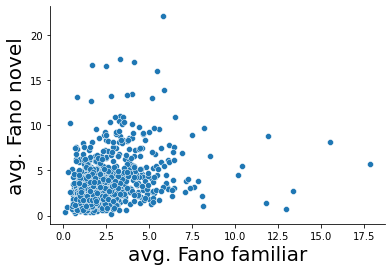

In [129]:
fig,ax=plt.subplots()
X_raw_sub =X_raw_all.loc[(slice(None),sess_two_tasks),:]
gpb=X_raw_sub.groupby(level=(0,1,2,4))
fano_per_neuron_fam_nov=gpb.apply(lambda x:(x.var(axis=1)/x.mean(axis=1)).mean()).unstack(level=2)
ax=sns.scatterplot(data=fano_per_neuron_fam_nov,x=0,y=1,ax=ax)
sns.despine()
ax.set_xlabel('avg. Fano familiar')
ax.set_ylabel('avg. Fano novel')

print(fano_per_neuron_fam_nov.rcorr())

for fmt in ['png','svg']:
    fig_fn = f'fano_novel_vs_fam.{fmt}'
    fig_fn_full = os.path.join(figdir,fig_fn)
    fig.savefig(fig_fn_full,bbox_inches='tight')

# individual ratemap examples of the four contingencies

examples:
sess = 'e15_13f1_220120'
fam true, novel false: uid=106

f,t 142, 239

f,f 



In [16]:
pval_min_perneuron_unstack_one = pval_all_sub_min_per_neuron_unstack.loc[ani,sess].dropna(axis=0)
fano_per_neuron_fam_nov_one = fano_per_neuron_fam_nov.loc[ani,sess].dropna(axis=0)

In [17]:
ma = (fano_per_neuron_fam_nov_one[0]<2) & (fano_per_neuron_fam_nov_one[1]>5)
fano_per_neuron_fam_nov_one.loc[ma]

,0,1
71,1.313388,5.343772
92,1.242533,6.190124
236,1.298953,6.272972
266,1.945485,5.203138


In [119]:
sig_thresh = 0.01
insig_thresh = 0.05
# ma = (pval_min_perneuron_unstack_one[1]<sig_thresh)&(pval_min_perneuron_unstack_one[0]>insig_thresh)
ma = (pval_min_perneuron_unstack_one[1]<sig_thresh)&(pval_min_perneuron_unstack_one[0]<sig_thresh)
pval_min_perneuron_unstack_one.loc[ma]

,0,1
42,0.000,0.002
47,0.003,0.000
53,0.002,0.000
61,0.000,0.001
66,0.000,0.003
69,0.000,0.002
73,0.000,0.000
76,0.000,0.000
79,0.000,0.005
80,0.000,0.002


In [121]:
figdir_ex = misc.get_or_create_subdir(figdir,'ratemap_ex')

/mnt/home/szheng/ceph/place_variability/fig/paper/figure_fam_also_nov/ratemap_ex made!


/tmp/ipykernel_737671/710846948.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax=sns.heatmap(fr_map_trial_df_all.loc[(ani,sess,isnovel),:].loc[tt].loc[uid].dropna(axis=1,how='all').T,cmap='Greys',ax=ax)


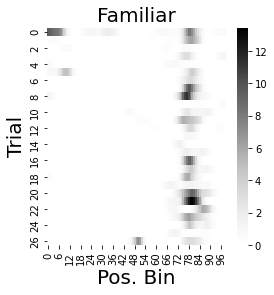

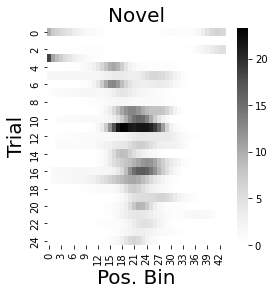

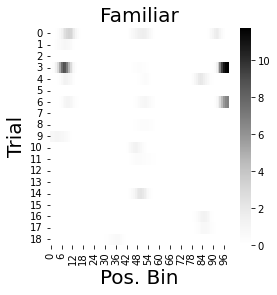

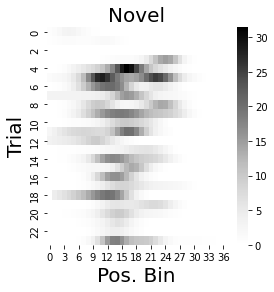

In [127]:
uid=142
dosavefig = True
isnovel_str_d = {0:'Familiar',1:'Novel'}
for tt in [0,1]:
    for isnovel in [0,1]:
        fig,ax=plt.subplots(figsize=(4,4))
        ax=sns.heatmap(fr_map_trial_df_all.loc[(ani,sess,isnovel),:].loc[tt].loc[uid].dropna(axis=1,how='all').T,cmap='Greys',ax=ax)
        ax.set_xlabel('Pos. Bin')
        ax.set_ylabel('Trial')
        ax.set_title(isnovel_str_d[isnovel])
        if dosavefig:
            for fmt in ['png','svg']:
                fig_fn = f'ratemap_{uid}_task_{isnovel}_tt_{tt}.{fmt}'
                fig_fn_full = os.path.join(figdir_ex,fig_fn)
                fig.savefig(fig_fn_full,bbox_inches='tight')



In [53]:
all_fields_recombined_one=all_fields_recombined_all.loc[ani,sess]

/tmp/ipykernel_737671/1625932169.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_recombined_one=all_fields_recombined_all.loc[ani,sess]


In [55]:
all_fields_recombined_one.loc[(0,slice(0),uid)]

,,,,start,end,com,peak,fr_peak,fr_mean,other_field_index
,,,field_index,,,,,,,
0,0.0,76,0,80,98,88,88,9.141049,5.904878,NaN


(<Figure size 864x288 with 3 Axes>,
 array([<Axes: xlabel='Peak firing rate (Hz)', ylabel='Trial'>,
        <Axes: xlabel='Pos. bin'>], dtype=object))

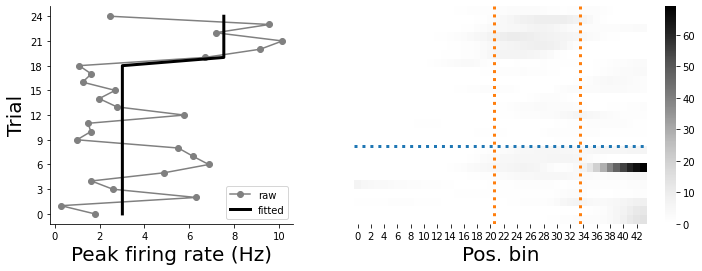

In [64]:
# spk_beh_df=spk_beh_df_all.loc[ani,sess]
# trial_index_to_index_within_df=dpp.trial_index_to_index_within_trialtype(spk_beh_df)

# fr_map_trial_df=fr_map_trial_df_all.loc[ani,sess]
# X_raw=X_raw_all.loc[ani,sess]
# X_pwc=X_pwc_all.loc[ani,sess]
# all_sw_d = all_sw_d_all.loc[ani,sess]


# need to debug!!!

# import plot_all_fr_map_x_pwc_one_session as plotfm
# # all_fields_row_one = all_fields_recombined_one.loc[(0,slice(0),uid)].iloc[0]
# all_fields_row_one = all_fields_recombined_one.loc[(1,slice(0),uid)].iloc[0]


# plotfm.plot_ratemap_fr_one_field(all_fields_row_one,fr_map_trial_df,X_raw,X_pwc,all_sw_d,
#                             trial_index_to_index_within_df,
#                             save_fig_fn = None,
#                             close_fig = False,
#                                 )